# Kaggle: Data Science Bowl 2019 - PBS KIDS Measure Up! app

In [266]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import features
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.svm import SVC 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, cohen_kappa_score, make_scorer, accuracy_score, mean_squared_error
from sklearn.pipeline import Pipeline
import inspect
import xgboost as xgb
from sklearn.utils import class_weight
from OrdinalRegressor import OrdinalRegressor
from OptimizeThresholds import OptimizedRounder


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Read Data From features.py

In [108]:
feats=pd.read_csv('installation_features_v2.csv')
labels=pd.read_csv('installation_labels_v2.csv')
test=pd.read_csv('test_feats_v2.csv')

In [109]:
print(feats.shape)
print(test.shape)

(17690, 533)
(1000, 533)


## Many Features are lognormal
Many of the features in the dataset are zero heavy with a lognormal distribution for values > 0 as shown below.
To address this, the preprocessing pipeline will log normalize many of the features:
 - event_code counts
 - event_id counts
 - total event counts for each activity type
 - game_times for each activity type
 

### Clip watchtimes / durations, video skips

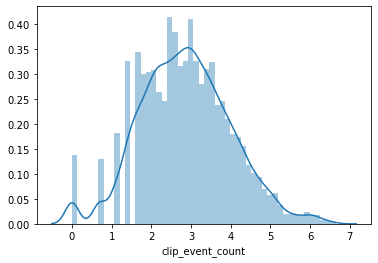

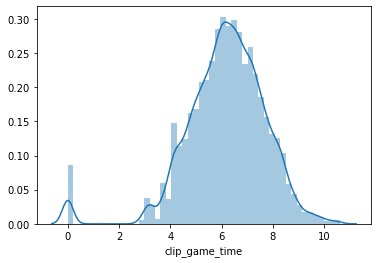

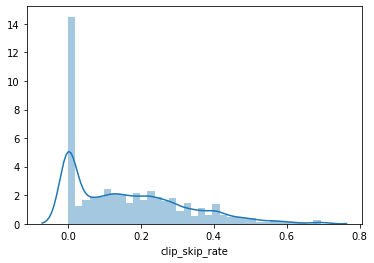

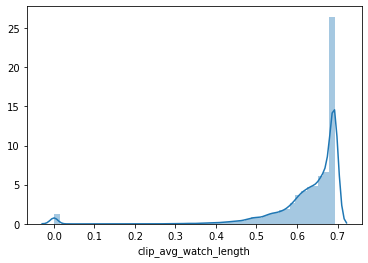

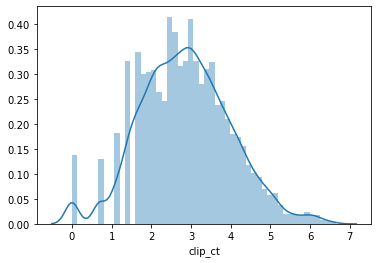

In [267]:
for c in [f for f in feats.columns if 'clip' in f]:
    sns.distplot(np.log1p(feats[c]))
    plt.show()

### Game times in all activity types

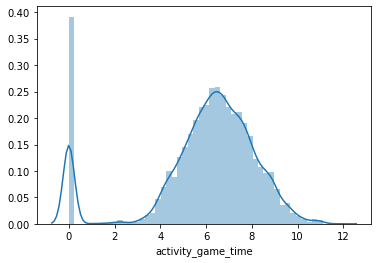

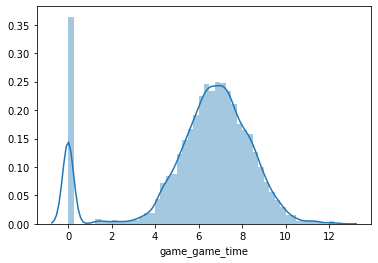

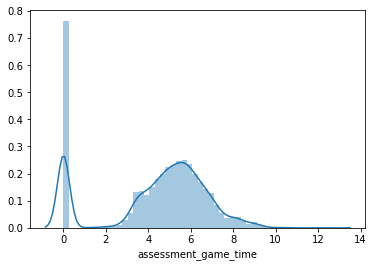

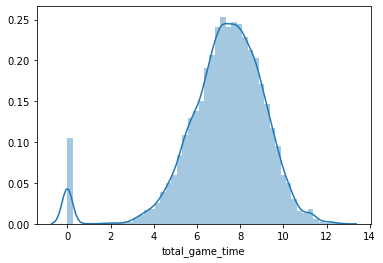

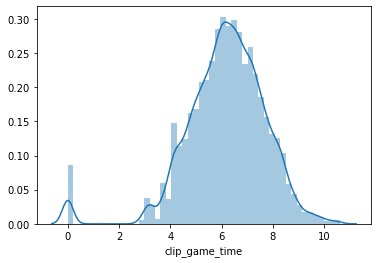

In [107]:
for c in [f for f in feats.dropna(thresh=2, axis=1).columns if f.endswith('game_time')]:
    sns.distplot(np.log1p(feats[c]))
    plt.show()

### Counts for each Event ID (eid)

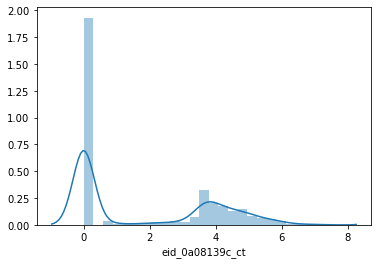

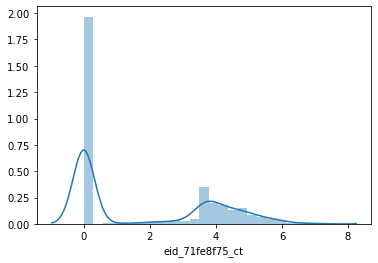

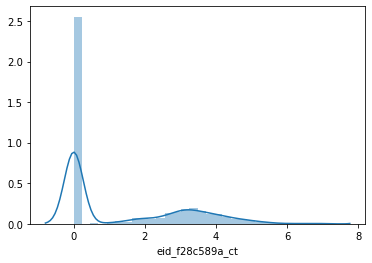

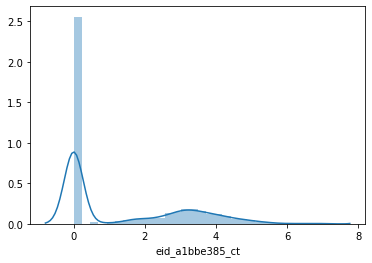

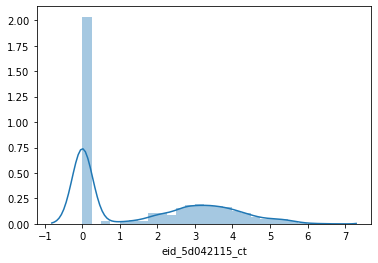

In [269]:
for c in [f for f in feats.dropna(thresh=2, axis=1).columns if f.startswith('eid_')][0:5]:
    sns.distplot(np.log1p(feats[c]))
    plt.show()

## Model Pipelines
### Data Preprocess Pipe
All of the features written to `installation_features_v2.csv` are raw integers / floats / strings for each installation, assessment training point. Before passing the feature vector to our models, a series of transformations are performed on the various columns and returned a vector of floats.  
 - arg: log_features: list[column_names] -> np.log1p transformation -> standard scalar
 - arg: categorical_features: list[column_names] -> one_hot_encoder
 - numerical_features: columns not in log_features + categorical_features -> standard scalar

In [113]:
feature_pipe=features.get_data_processing_pipe(feats,
                                               log_features=list(filter(lambda c: c.startswith('event') or 
                                                                                  c.endswith('event_count') or
                                                                                  c.endswith('game_time') or
                                                                                  c.startswith('eid_'), 
                                                                        feats.columns)), 
                                               categorical_features=['last_world', 'last_assessment'])

### User Based KFold Splits
CV scores on regular Kfold splits yielding greater quadratic weighted kappa scores compared to final private data set scores on Kaggle. This is partially due to data leakages when different assessments for the same `installation_id` are split amongst the train and eval sets. Since the test set is on entirely new users. We should simulate similar K eval sets with `installation_id`s that are distinct from the training set. This is done using the UserCV subclass of kfold that assigns a set percentage of `installation_id`s to each fold rather than random rows. This will result in slightly higher variance in end train/test size but users remain in distinct groups.

In [138]:
class UserCV(KFold):
    def __init__(self, n_splits, split_key, test_pct=None, shuffle=False, random_state=None):
        super().__init__(n_splits=n_splits, shuffle=shuffle, random_state=random_state)
        self.split_column = split_key
        self.test_pct = test_pct if test_pct else 1.0/n_splits
    
    def get_n_splits(self, X, y):
        myCViterator = []
        unique_keys = X[self.split_column].unique()
        cv_assignments = dict(zip(unique_keys, np.random.randint(int(1/self.test_pct), size=unique_keys.size)))
        X['cv_fold'] = X[self.split_column].apply(lambda x_id: cv_assignments[x_id])
        for i in range(self.n_splits):
            trainIndices = X[ X['cv_fold']!=i ].index.values.astype(int)
            testIndices =  X[ X['cv_fold']==i ].index.values.astype(int)
            myCViterator.append( (trainIndices, testIndices) )
        return myCViterator
    
cv_folds = UserCV(n_splits=5, split_key='installation_id', test_pct=0.10).get_n_splits(feats, labels.accuracy_group)

In [139]:
cv_folds[0][1].shape[0] / cv_folds[0][0].shape[0]

0.1179221435793731

### Ordinal Regression
The goal of this project is to predict the assessment outcomes of young children based on their activity within the PBS educational app. Initial attempts we made were with traditional classifiers that aim to minimize softmax cross entropy amongst the four classes and maximize accuracy. However, this ignores the ordinal nature of our output classes:
3: the assessment was solved on the first attempt  
2: the assessment was solved on the second attempt  
1: the assessment was solved after 3 or more attempts  
0: the assessment was never solved  
minimize the quadratic weighted kappa metric. 

### Tune XGBRegressor

In [272]:
# X_train and X_test are first set from UserCV splits
X_train, X_test, y_train, y_test = feats.iloc[cv_folds[0][0]], feats.iloc[cv_folds[0][1]], labels.accuracy_group.iloc[cv_folds[0][0]], labels.accuracy_group.iloc[cv_folds[0][1]]

### setup the pipeline
ordinal_pipe = Pipeline(steps=[
    ('preprocess', feature_pipe),
    ('clf', OrdinalRegressor(xgb.XGBRegressor,
                              **{}))])

In [118]:
# rmse scored for the classifier inside OrdinalRegressor, in this case XGBRegressor

regressor_kappa_score = make_scorer(lambda y, y_pred: cohen_kappa_score(y, y_pred, weights='quadratic'), needs_proba=True)
regressor_accuracy_score = make_scorer(lambda y, y_pred: accuracy_score(y, y_pred), needs_proba=True)

ordinal_cv = GridSearchCV(ordinal_pipe, cv=cv_folds, n_jobs=8,
                      scoring={'kappa': regressor_kappa_score,
                               'accuracy': regressor_accuracy_score,
                               'rmse': make_scorer(mean_squared_error, greater_is_better=False)},
                      param_grid={'clf__n_estimators': [100, 300],
                                  'clf__reg_alpha': [0.1, 1, 10],
                                  'clf__max_depth': [5, 7, 9],
                                  'clf__learning_rate': [0.01, 0.03],
                                  'clf__subsample': [0.8],
                                  'clf__colsample_bytree': [0.1, 0.3, 0.5]},
                      refit='rmse',
                      verbose=2)
ordinal_cv.fit(feats, labels.accuracy_group)
pd.DataFrame(ordinal_cv.cv_results_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   53.3s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:  5.8min
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed: 19.7min
[Parallel(n_jobs=8)]: Done 540 out of 540 | elapsed: 40.4min finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__colsample_bytree,param_clf__learning_rate,param_clf__max_depth,param_clf__n_estimators,param_clf__reg_alpha,param_clf__subsample,...,std_test_accuracy,rank_test_accuracy,split0_test_rmse,split1_test_rmse,split2_test_rmse,split3_test_rmse,split4_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse
0,8.663082,0.078844,0.088323,0.007228,0.1,0.01,5,100,0.1,0.8,...,0.007826,107,-1.552064,-1.587611,-1.649410,-1.565664,-1.484213,-1.567792,0.053463,106
1,8.813667,0.210757,0.104527,0.019837,0.1,0.01,5,100,1,0.8,...,0.008498,108,-1.553101,-1.588816,-1.656658,-1.566450,-1.482823,-1.569569,0.056144,107
2,8.771481,0.071057,0.098817,0.008254,0.1,0.01,5,100,10,0.8,...,0.007982,106,-1.566023,-1.599407,-1.677165,-1.578514,-1.481578,-1.580538,0.062770,108
3,21.299906,0.203009,0.103067,0.011385,0.1,0.01,5,300,0.1,0.8,...,0.035786,34,-1.112131,-1.209755,-1.195454,-1.166221,-1.151073,-1.166927,0.034358,79
4,21.565117,0.351722,0.112749,0.013231,0.1,0.01,5,300,1,0.8,...,0.036223,57,-1.110942,-1.208893,-1.203824,-1.165937,-1.151142,-1.168148,0.036054,80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,35.399766,0.197475,0.120367,0.009954,0.5,0.03,9,100,1,0.8,...,0.021322,33,-0.960288,-1.054048,-1.033537,-1.023231,-0.965085,-1.007238,0.037735,19
104,36.155333,2.253490,0.161612,0.052433,0.5,0.03,9,100,10,0.8,...,0.020112,53,-0.954671,-1.059907,-1.062194,-1.024820,-0.951891,-1.010697,0.048724,21
105,101.219221,0.614665,0.157429,0.023350,0.5,0.03,9,300,0.1,0.8,...,0.015957,52,-0.946627,-1.053922,-1.019000,-1.014393,-0.968999,-1.000588,0.038168,16
106,98.126597,3.512704,0.136137,0.009692,0.5,0.03,9,300,1,0.8,...,0.017807,58,-0.947081,-1.039917,-1.016619,-1.016045,-0.939223,-0.991777,0.040702,13


In [123]:
pd.DataFrame(ordinal_cv.cv_results_).sort_values('mean_test_rmse', ascending=False).head(10)#[['mean_test_kappa', 'mean_test_accuracy', 'mean_test_rmse']]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__colsample_bytree,param_clf__learning_rate,param_clf__max_depth,param_clf__n_estimators,param_clf__reg_alpha,param_clf__subsample,...,std_test_accuracy,rank_test_accuracy,split0_test_rmse,split1_test_rmse,split2_test_rmse,split3_test_rmse,split4_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse
65,51.223993,0.261241,0.133640,0.011052,0.3,0.03,7,300,10,0.8,...,0.020750,17,-0.921696,-1.007778,-1.005734,-0.986542,-0.940914,-0.972533,0.035000,1
71,66.099671,0.462782,0.133071,0.012640,0.3,0.03,9,300,10,0.8,...,0.016888,5,-0.933741,-1.008302,-1.018451,-1.007384,-0.918855,-0.977347,0.042126,2
101,74.613362,0.234221,0.139755,0.014585,0.5,0.03,7,300,10,0.8,...,0.019533,23,-0.926492,-1.015232,-1.009265,-1.009274,-0.929518,-0.977956,0.040854,3
59,37.555764,0.276846,0.122049,0.011785,0.3,0.03,5,300,10,0.8,...,0.022097,31,-0.922676,-1.004871,-1.008945,-0.990562,-0.964558,-0.978322,0.031870,4
58,37.221988,0.279769,0.120861,0.008918,0.3,0.03,5,300,1,0.8,...,0.025289,30,-0.923237,-1.002677,-1.011889,-0.997548,-0.962009,-0.979472,0.032813,5
57,37.145045,0.170015,0.121649,0.009418,0.3,0.03,5,300,0.1,0.8,...,0.014910,70,-0.923808,-0.997224,-1.019686,-0.999103,-0.962209,-0.980406,0.033793,6
100,74.070656,0.574751,0.128872,0.008228,0.5,0.03,7,300,1,0.8,...,0.015261,25,-0.925753,-1.022511,-1.000934,-1.011657,-0.943663,-0.980904,0.038747,7
99,73.856340,0.507286,0.130453,0.019644,0.5,0.03,7,300,0.1,0.8,...,0.011175,40,-0.932845,-1.027002,-1.004413,-1.007113,-0.946990,-0.983673,0.036840,8
107,88.880825,3.299850,0.104749,0.011940,0.5,0.03,9,300,10,0.8,...,0.028414,54,-0.933058,-1.042451,-1.025423,-1.008640,-0.922626,-0.986439,0.049136,9
95,53.550305,0.268542,0.118072,0.007963,0.5,0.03,5,300,10,0.8,...,0.019557,69,-0.922646,-1.020055,-1.016029,-1.001912,-0.993858,-0.990900,0.035412,10


In [124]:
pd.DataFrame(ordinal_cv.cv_results_).sort_values('mean_test_rmse', ascending=False).head(10)[['mean_test_kappa', 'rank_test_kappa', 'mean_test_accuracy', 'rank_test_accuracy', 'mean_test_rmse', 'rank_test_rmse']]

,mean_test_kappa,rank_test_kappa,mean_test_accuracy,rank_test_accuracy,mean_test_rmse,rank_test_rmse
65,0.606775,3,0.516560,17,-0.972533,1
71,0.604196,6,0.521237,5,-0.977347,2
101,0.605910,4,0.514226,23,-0.977956,3
59,0.609249,1,0.512387,31,-0.978322,4
58,0.608534,2,0.512907,30,-0.979472,5
57,0.602893,7,0.500784,70,-0.980406,6
100,0.604418,5,0.513503,25,-0.980904,7
99,0.602054,8,0.509451,40,-0.983673,8
107,0.592761,32,0.504974,54,-0.986439,9
95,0.597625,13,0.501563,69,-0.990900,10


In [271]:
params = pd.DataFrame(ordinal_cv.cv_results_).sort_values('mean_test_rmse', ascending=False)['params'].values[0]
params = {k.replace('clf__', ''): v for k, v in params.items()}
print(params)

{'colsample_bytree': 0.3, 'learning_rate': 0.03, 'max_depth': 7, 'n_estimators': 300, 'reg_alpha': 10, 'subsample': 0.8}


In [193]:
xgb_pipe = Pipeline(steps=[
    ('preprocess', feature_pipe),
    ('clf', OrdinalRegressor(xgb.XGBRegressor,
                              **{'colsample_bytree': 0.3, 'learning_rate': 0.03, 'max_depth': 7, 'n_estimators': 300, 'reg_alpha': 10, 'subsample': 0.8}))])


xgb_pipe.fit(X_train, y_train, clf__eval_set=[(X_test_transform, y_test)])
xgb_y_cont = ordinal_pipe.predict(X_test)
y_pred = xgb_pipe.predict(X_test, **{'classify': True})
print((y_pred==y_test).mean())
print(cohen_kappa_score(y1=y_test, y2=y_pred, weights='quadratic'))
confusion_matrix(y_test, y_pred)

[0]	validation_0-rmse:1.82575
[1]	validation_0-rmse:1.79024
[2]	validation_0-rmse:1.75605
[3]	validation_0-rmse:1.72503
[4]	validation_0-rmse:1.69336
[5]	validation_0-rmse:1.66562
[6]	validation_0-rmse:1.63722
[7]	validation_0-rmse:1.60854
[8]	validation_0-rmse:1.58045
[9]	validation_0-rmse:1.55521
[10]	validation_0-rmse:1.53086
[11]	validation_0-rmse:1.50780
[12]	validation_0-rmse:1.48556
[13]	validation_0-rmse:1.46412
[14]	validation_0-rmse:1.44277
[15]	validation_0-rmse:1.42339
[16]	validation_0-rmse:1.40432
[17]	validation_0-rmse:1.38631
[18]	validation_0-rmse:1.36853
[19]	validation_0-rmse:1.35146
[20]	validation_0-rmse:1.33777
[21]	validation_0-rmse:1.32225
[22]	validation_0-rmse:1.30844
[23]	validation_0-rmse:1.29587
[24]	validation_0-rmse:1.28333
[25]	validation_0-rmse:1.27123
[26]	validation_0-rmse:1.25876
[27]	validation_0-rmse:1.24632
[28]	validation_0-rmse:1.23508
[29]	validation_0-rmse:1.22528
[30]	validation_0-rmse:1.21568
[31]	validation_0-rmse:1.20574
[32]	validation_0-

array([[235,  78,  71,  45],
       [ 45,  80,  85,  62],
       [ 17,  42,  88,  98],
       [ 24,  90, 270, 536]])

### Tune TF Sequential Model MLP

In [207]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

def build_model(input_shape=[538], hidden_units=[64], learning_rate=0.003, dropout=0, l1=0, l2=0, epochs=20):
    model = keras.Sequential([
        layers.Input(input_shape)
    ])
    for hu in hidden_units:
        model.add(layers.Dense(hu, activation=tf.keras.layers.LeakyReLU(), kernel_regularizer=keras.regularizers.l1_l2(l1=l1, l2=l2)))
        model.add(layers.Dropout(dropout))
    model.add(layers.Dense(1))

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

params = {
    'hidden_units': (128,),
    'dropout': 0.1,
    'learning_rate': 0.0001,
    'l1': 0.0001,
    'l2': 0.0,
    'epochs': 20
}  

mlp_keras = tf.keras.wrappers.scikit_learn.KerasRegressor(build_model, **params)
mlp_keras.fit(X_train_transform, y_train, validation_data=(X_test_transform, y_test), verbose=1)
mlp_y_cont = mlp_keras.predict(X_test_transform)

Train on 15824 samples, validate on 1866 samples
Epoch 1/20
15824/15824 [==============================] - 4s 274us/sample - loss: 2.2862 - mae: 1.1601 - mse: 1.9611 - val_loss: 1.6382 - val_mae: 0.9676 - val_mse: 1.3144
Epoch 2/20
15824/15824 [==============================] - 4s 243us/sample - loss: 1.6962 - mae: 0.9663 - mse: 1.3736 - val_loss: 1.4842 - val_mae: 0.8910 - val_mse: 1.1629
Epoch 3/20
15824/15824 [==============================] - 3s 211us/sample - loss: 1.5636 - mae: 0.9114 - mse: 1.2435 - val_loss: 1.4203 - val_mae: 0.8555 - val_mse: 1.1015
Epoch 4/20
15824/15824 [==============================] - 3s 216us/sample - loss: 1.4904 - mae: 0.8787 - mse: 1.1728 - val_loss: 1.3852 - val_mae: 0.8380 - val_mse: 1.0690
Epoch 5/20
15824/15824 [==============================] - 3s 213us/sample - loss: 1.4747 - mae: 0.8729 - mse: 1.1598 - val_loss: 1.3790 - val_mae: 0.8412 - val_mse: 1.0655
Epoch 6/20
15824/15824 [==============================] - 4s 223us/sample - loss: 1.4344 - 

array([1.1903926 , 2.877315  , 2.815726  , ..., 0.79190505, 2.0478756 ,
       1.8136898 ], dtype=float32)

In [202]:
mlp_pipe = Pipeline(steps=[
    ('preprocess', feature_pipe),
    ('clf', tf.keras.wrappers.scikit_learn.KerasRegressor(build_model))])

mlp_cv = GridSearchCV(mlp_pipe, cv=cv_folds, n_jobs=8,
                      scoring={'rmse': make_scorer(mean_squared_error, greater_is_better=False)},
                      param_grid={'clf__hidden_units': [(128,), (128, 128)],
                                  'clf__dropout': [0, 0.1],
                                  'clf__learning_rate': [0.0001, 0.00001],
                                  'clf__l1': [0.0, 0.001],
                                  'clf__l2': [0.0],
                                  'clf__epochs': [20]
                                  },
                      refit='rmse',
                      verbose=2)
mlp_cv.fit(feats, labels.accuracy_group)
pd.DataFrame(mlp_cv.cv_results_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:  6.9min
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed: 19.1min finished


Train on 17690 samples
Epoch 1/20
17690/17690 [==============================] - 4s 238us/sample - loss: 5.1263 - mae: 1.1503 - mse: 1.9464
Epoch 2/20
17690/17690 [==============================] - 3s 195us/sample - loss: 4.3233 - mae: 0.9507 - mse: 1.3338
Epoch 3/20
17690/17690 [==============================] - 4s 203us/sample - loss: 4.0236 - mae: 0.9024 - mse: 1.2141
Epoch 4/20
17690/17690 [==============================] - 4s 223us/sample - loss: 3.7978 - mae: 0.8759 - mse: 1.1553
Epoch 5/20
17690/17690 [==============================] - 3s 179us/sample - loss: 3.6129 - mae: 0.8624 - mse: 1.1242
Epoch 6/20
17690/17690 [==============================] - 3s 198us/sample - loss: 3.4358 - mae: 0.8477 - mse: 1.0889
Epoch 7/20
17690/17690 [==============================] - 3s 190us/sample - loss: 3.3015 - mae: 0.8446 - mse: 1.0852
Epoch 8/20
17690/17690 [==============================] - 3s 181us/sample - loss: 3.1616 - mae: 0.8392 - mse: 1.0679
Epoch 9/20
17690/17690 [=================

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__dropout,param_clf__epochs,param_clf__hidden_units,param_clf__l1,param_clf__l2,param_clf__learning_rate,params,split0_test_rmse,split1_test_rmse,split2_test_rmse,split3_test_rmse,split4_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse
0,84.152416,3.358158,0.658418,0.072927,0,20,"(128,)",0,0,0.0001,"{'clf__dropout': 0, 'clf__epochs': 20, 'clf__h...",-1.075699,-1.052541,-1.520035,-1.064393,-1.118977,-1.166329,0.178271,10
1,90.990586,4.597965,0.763527,0.119094,0,20,"(128,)",0,0,1e-05,"{'clf__dropout': 0, 'clf__epochs': 20, 'clf__h...",-1.145228,-1.267091,-1.966748,-1.115671,-1.153936,-1.329735,0.322639,14
2,102.078564,2.579113,0.865808,0.184803,0,20,"(128,)",0.001,0,0.0001,"{'clf__dropout': 0, 'clf__epochs': 20, 'clf__h...",-1.092270,-1.118577,-1.288180,-1.026613,-1.116243,-1.128377,0.086533,7
3,105.745132,2.319682,0.751055,0.241853,0,20,"(128,)",0.001,0,1e-05,"{'clf__dropout': 0, 'clf__epochs': 20, 'clf__h...",-1.101534,-1.125152,-2.378018,-1.116964,-1.152889,-1.374912,0.501830,15
4,107.954588,2.629189,0.641642,0.078105,0,20,"(128, 128)",0,0,0.0001,"{'clf__dropout': 0, 'clf__epochs': 20, 'clf__h...",-1.072137,-1.130577,-1.084397,-1.075155,-1.100695,-1.092592,0.021439,5
5,111.726642,5.500775,0.946281,0.205211,0,20,"(128, 128)",0,0,1e-05,"{'clf__dropout': 0, 'clf__epochs': 20, 'clf__h...",-1.141528,-1.163283,-1.357479,-1.057055,-1.166769,-1.177223,0.098499,11
6,127.937723,4.273029,0.900927,0.127147,0,20,"(128, 128)",0.001,0,0.0001,"{'clf__dropout': 0, 'clf__epochs': 20, 'clf__h...",-1.063433,-1.013888,-1.058927,-1.025976,-1.050881,-1.042621,0.019339,2
7,131.290984,2.262198,0.922555,0.259211,0,20,"(128, 128)",0.001,0,1e-05,"{'clf__dropout': 0, 'clf__epochs': 20, 'clf__h...",-1.107591,-1.161484,-1.854646,-1.116297,-1.084158,-1.264835,0.295970,13
8,97.223720,4.343058,0.584187,0.105681,0.1,20,"(128,)",0,0,0.0001,"{'clf__dropout': 0.1, 'clf__epochs': 20, 'clf_...",-1.075073,-1.039881,-1.063573,-1.041617,-1.090872,-1.062203,0.019552,3
9,84.147105,3.585055,0.664822,0.239998,0.1,20,"(128,)",0,0,1e-05,"{'clf__dropout': 0.1, 'clf__epochs': 20, 'clf_...",-1.137230,-1.171128,-1.479210,-1.118193,-1.153483,-1.211849,0.134823,12


In [205]:
pd.DataFrame(mlp_cv.cv_results_).sort_values('mean_test_rmse', ascending=False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__dropout,param_clf__epochs,param_clf__hidden_units,param_clf__l1,param_clf__l2,param_clf__learning_rate,params,split0_test_rmse,split1_test_rmse,split2_test_rmse,split3_test_rmse,split4_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse
10,99.461656,3.909567,0.648275,0.189093,0.1,20,"(128,)",0.001,0,0.0001,"{'clf__dropout': 0.1, 'clf__epochs': 20, 'clf_...",-1.026336,-1.001402,-1.084361,-1.024628,-1.049338,-1.037213,0.028032,1
6,127.937723,4.273029,0.900927,0.127147,0,20,"(128, 128)",0.001,0,0.0001,"{'clf__dropout': 0, 'clf__epochs': 20, 'clf__h...",-1.063433,-1.013888,-1.058927,-1.025976,-1.050881,-1.042621,0.019339,2
8,97.223720,4.343058,0.584187,0.105681,0.1,20,"(128,)",0,0,0.0001,"{'clf__dropout': 0.1, 'clf__epochs': 20, 'clf_...",-1.075073,-1.039881,-1.063573,-1.041617,-1.090872,-1.062203,0.019552,3
12,115.409824,3.114241,0.969080,0.438780,0.1,20,"(128, 128)",0,0,0.0001,"{'clf__dropout': 0.1, 'clf__epochs': 20, 'clf_...",-1.051840,-1.064215,-1.242223,-1.012963,-1.042564,-1.082761,0.081506,4
4,107.954588,2.629189,0.641642,0.078105,0,20,"(128, 128)",0,0,0.0001,"{'clf__dropout': 0, 'clf__epochs': 20, 'clf__h...",-1.072137,-1.130577,-1.084397,-1.075155,-1.100695,-1.092592,0.021439,5


### Combine XGBoost and MLP in Voting Regressor

In [219]:
from sklearn.ensemble import VotingRegressor
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

# _estimator_type required for VotingRegressor Ensemble
class KerasRegressor_v2(KerasRegressor):
    def __init__(self, build_fn, **kwargs):
        super().__init__(build_fn, **kwargs)
        self._estimator_type = "regressor"


In [276]:
xgb_params = {'colsample_bytree': 0.3, 
              'learning_rate': 0.03, 
              'max_depth': 9, 
              'n_estimators': 300, 
              'reg_alpha': 10, 
              'subsample': 0.8}
mlp_params = {
    'hidden_units': (128,),
    'dropout': 0.1,
    'learning_rate': 0.0001,
    'l1': 0.0001,
    'l2': 0.0,
    'epochs': 20
}  
                      
ordinal_pipe = Pipeline(steps=[
    ('preprocess', feature_pipe),
    ('clf', OrdinalRegressor(VotingRegressor, estimators=[('xgb', xgb.XGBRegressor(**xgb_params)), 
                                                          ('mlp', KerasRegressor_v2(build_model, **mlp_params))],
                                              weights=(0.7,0.3)))])
                      
    
ordinal_pipe.fit(X_train, y_train)
ensemble_y_cont = ordinal_pipe.predict(X_test)
y_pred = ordinal_pipe.predict(X_test, **{'classify': True})
print((y_pred==y_test).mean())
print(cohen_kappa_score(y1=y_test, y2=y_pred, weights='quadratic'))
confusion_matrix(y_test, y_pred)

Train on 15824 samples
Epoch 1/20
15824/15824 [==============================] - 3s 215us/sample - loss: 2.3832 - mae: 1.1835 - mse: 2.0566
Epoch 2/20
15824/15824 [==============================] - 3s 182us/sample - loss: 1.7077 - mae: 0.9723 - mse: 1.3831
Epoch 3/20
15824/15824 [==============================] - 3s 184us/sample - loss: 1.5644 - mae: 0.9078 - mse: 1.2416
Epoch 4/20
15824/15824 [==============================] - 2s 157us/sample - loss: 1.5134 - mae: 0.8838 - mse: 1.1925
Epoch 5/20
15824/15824 [==============================] - 3s 178us/sample - loss: 1.4823 - mae: 0.8700 - mse: 1.1634
Epoch 6/20
15824/15824 [==============================] - 3s 211us/sample - loss: 1.4353 - mae: 0.8541 - mse: 1.1186
Epoch 7/20
15824/15824 [==============================] - 3s 179us/sample - loss: 1.4261 - mae: 0.8503 - mse: 1.1116
Epoch 8/20
15824/15824 [==============================] - 3s 172us/sample - loss: 1.4079 - mae: 0.8422 - mse: 1.0957
Epoch 9/20
15824/15824 [=================

array([[238,  83,  63,  45],
       [ 52,  74,  90,  56],
       [ 19,  38,  82, 106],
       [ 33,  72, 249, 566]])

**On a single train/test split, the ensemble(xgb * 0.7 + mlp * 0.3) increases QWK score from 0.5755 to 0.5906 compared to xgb model alone**

### Ensemble estimator variation

In [239]:
ensemble_y_cont = ordinal_pipe.predict(X_test)
X_test_transform = ordinal_pipe['preprocess'].transform(X_test)
xgb_y_cont = ordinal_pipe['clf'].clf.estimators_[0].predict(X_test_transform)
mlp_y_cont = ordinal_pipe['clf'].clf.estimators_[1].predict(X_test_transform)

In [240]:
mean_squared_error(y_test, xgb_y_cont)

0.9762387915680588

Scatter plot of xgb vs mlp predictions, lines indicated final optimized thresholds

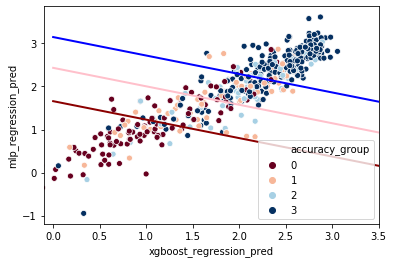

In [288]:
sample = np.random.choice(range(y_test.size), size=int(y_test.size/4), replace=False)
f = sns.scatterplot(xgb_y_cont[sample], mlp_y_cont[sample], hue=y_test.iloc[sample], palette="RdBu")
f.set_xlabel('xgboost_regression_pred')
f.set_ylabel('mlp_regression_pred')
col=['darkred', 'pink', 'blue']
for i, c in enumerate(ordinal_pipe['clf'].threshold_optimizer.coef_.x):
    plt.plot([0, c/0.3], [c/0.7, 0], linewidth=2, color=col[i])
plt.xlim((-0.1, 3.5)) 
plt.show()

The regression predictions between the two models is highly correlated, however, there is some mild variation that improves some of the uncertainty within the middle 1, 2 accuracy groups

**The final private score on the Kaggle competition for this model is 0.544 (top 3% out of ~3500 submissions)**